In [1]:
import numpy as np
import os
CurrentPath = os.getcwd()
data_1 = np.loadtxt(CurrentPath + '/2025/data_1.txt', delimiter=' ')
X = data_1.T[0];Y = data_1.T[1]; var = data_1.T[2]
import matplotlib.pyplot as plt
import corner

In [ ]:
import nestle

#define loglikelihood
def loglike_linear(theta):
    model = linear(X,theta) # Change the model here
    loglikelihood = -0.5*np.sum((Y-model)**2/var)
    return(loglikelihood)

#define models
def linear(x, theta):
    y= theta[0]*x + theta[1]
    return y
def cube(x,theta):
    y = theta[0]*x**3 + theta[1]*x**2 + theta[2]*x + theta[3]
    return y
def quadratic(x,theta):
    y = theta[0]*x**2 + theta[1]*x + theta[2]
    return y
def exponential(x,theta):
    y = theta[0]*np.exp(theta[1]*x) + theta[2]
    return y
def powerlaw(x,theta):
    y = theta[0]*x**theta[1] + theta[2]
    return y


### Let's make MCMC again!

1. make a code that accounts for a prior
2. make a code that calculates the acceptance ratio from the burn-in period -> ratio to 0.1 <= accept/total <= 0.4
3. do 100 steps -> calculate accept ratio -> use std to proposed gaussian 
4. if 10 times accept ratio converges between that area, do the chain
5. remove the burn-in after the chain is finished

In [3]:
from tqdm import tqdm

# 1. make a code that acoounts for a prior
def ln_prior(min,max):
    volume = np.sum(np.abs(min - max)) # volume of the prior
    return np.log(1/volume)
        
def Loglikelihood(func, parm, x0,y0,var): # return Loglikelihood = -chisq
    diff = (y0 - func(x0, parm))**2
    chisq = np.sum(diff/var)
    return -chisq

def ln_f(func, param, x0, y0, var, prior, lnprior): # return total Loglikelihood
    bool = np.all((prior[0] <= param) & (param <= prior[1]))
    if bool == True:
        return lnprior + Loglikelihood(func, param, x0,y0,var)
    else:
        return -np.inf

def Markov(func, paramk,paramkp1,x,y,var, prior, lnprior):
    minuschisqk = ln_f(func, paramk, x,y,var, prior, lnprior)
    minuschisqkp1 = ln_f(func, paramkp1, x,y,var, prior, lnprior)
    lnr = np.log(np.random.uniform(0.,1.))

    if minuschisqkp1 - minuschisqk > lnr:
#        print(f"param0 = {paramk}, paramkp1 = {paramkp1}, \n chisq0 = {minuschisqk}, chisqkp1 = {minuschisqkp1}, lnr = {lnr}, moved : True")
        return paramkp1, minuschisqkp1
    else:
#        print(f"param0 = {paramk}, paramkp1 = {paramkp1}, \n chisq0 = {minuschisqk}, chisqkp1 = {minuschisqkp1}, lnr = {lnr}, moved : False")
        return paramk, minuschisqk  

# 2. make a code that calculates the acceptance ratio from the burn-in period -> ratio to 0.1 <= accept/total <= 0.4
def MCMC(func, paraminit, nstep,normal_vec,x,y,var, prior):
    lnprior = ln_prior(prior[0], prior[1]) # calculate the prior volume likelihood
    param0 = paraminit
    arr = np.zeros((len(param0) + 1,nstep))
    stepsize = normal_vec
    for k in tqdm(range(nstep)):
        paramkp1 = np.array(param0 + np.random.normal(0,stepsize))
        param0, loglikelihood = Markov(func, param0, paramkp1,x,y,var, prior, lnprior) #loglikelihood = -chisq
        col = np.hstack((param0, loglikelihood))
        arr[:,k] = col
    return arr

### linear function

In [ ]:
import scipy
def func(x, a, b):
    y = a * x + b
    return y

b, pcov = scipy.optimize.curve_fit(func, X, Y, sigma = np.sqrt(var))
print(f"a = {b[0]}, b = {b[1]}")
print(f"sigma = {np.sqrt(pcov[0][0])}, {np.sqrt(pcov[1][1])}")

a = 5726.207793380565, b = -117888.57784198274
sigma = 597.2939751240209, 28463.99539843442


In [ ]:
import matplotlib.pyplot as plt
import corner


def prior_linear(x):
    theta = np.array([597.2939751240209*20,28463.99539843442*20]) * x + np.array([5726.207793380565 - 597.2939751240209*10,-117888.57784198274-28463.99539843442*10])
    return theta

result_linear = nestle.sample(loglike_linear, prior_linear, 2,npoints=1000, method='single', callback=nestle.print_progress)
print(result_linear.summary(), f"\nlogzerr: {result_linear.logzerr}")
p_linear, cov_linear = nestle.mean_and_cov(result_linear.samples, result_linear.weights)
print(f"Best-fit parameters: a = {p_linear[0]:.3f} +/- {np.sqrt(cov_linear[0,0]):.3f}")
print(f"Best-fit parameters: b = {p_linear[1]:.3f} +/- {np.sqrt(cov_linear[1,1]):.3f}")

plt.figure(figsize=(10, 6))
plt.errorbar(X, Y, np.sqrt(var), fmt='o', label='Data')
plt.plot(X, linear(X, p_linear), label='Best-fit linear model')
plt.text(0.1,13, f"y = {p_linear[0]:.3f}x + {p_linear[1]:.3f}")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
fig = corner.corner(result_linear.samples,weights=result_linear.weights, labels=['a', 'b'],
                    range=[0.99999, 0.99999], bins=30)
plt.show()

### quadratic func

In [77]:
import scipy
def func(x, a, b, c):
    y = a * x**2 + b * x + c
    return y

scipy.optimize.curve_fit(func, X, Y, sigma = np.sqrt(var))

(array([  102.84103167, -3808.53901512, 28194.93525741]),
 array([[ 1.02660133e+01, -9.51797508e+02,  1.45826549e+04],
        [-9.51797508e+02,  9.60426694e+04, -1.66250220e+06],
        [ 1.45826549e+04, -1.66250220e+06,  3.84240854e+07]]))

In [84]:
#cubic function
a_init = np.random.uniform(102.84103167-5*np.sqrt(1.02660133e+01),102.84103167+5*np.sqrt(1.02660133e+01))
b_init = np.random.uniform(-3808.53901512-5*np.sqrt(9.60426694e+04),-3808.53901512+5*np.sqrt(9.60426694e+04))
c_init = np.random.uniform(28194.93525741-5*np.sqrt(3.84240854e+07),28194.93525741+5*np.sqrt(3.84240854e+07))

prior = np.array([[102.84103167-10*np.sqrt(1.02660133e+01),-3808.53901512-10*np.sqrt(9.60426694e+04),28194.93525741-10*np.sqrt(3.84240854e+07)]
                  ,[102.84103167+10*np.sqrt(1.02660133e+01),-3808.53901512+10*np.sqrt(9.60426694e+04),28194.93525741+10*np.sqrt(3.84240854e+07)]])

paraminit = np.array([a_init, b_init, c_init])
nstep = int(1e5)
normal_vec_initial = np.array([np.sqrt(1.02660133e+01), np.sqrt(9.60426694e+04), np.sqrt(3.84240854e+07)])
print(f"initial normal_vec = {normal_vec_initial}")
mcmcarr = MCMC(quadratic, paraminit, nstep,normal_vec_initial,X,Y,var, prior)
bestfitind = mcmcarr[3].argmax()
bestfitparm = [mcmcarr[0][bestfitind], mcmcarr[1][bestfitind], mcmcarr[2][bestfitind]]
bestfitval = mcmcarr[3][bestfitind]
print(f"bestfitparm = {bestfitparm}")
print(f'bestfitval = {bestfitval}, chisq = {-bestfitval*2}')

initial normal_vec = [3.20406200e+00 3.09907517e+02 6.19871643e+03]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:07<00:00, 13272.06it/s]

bestfitparm = [102.84511682697845, -3804.5359667796984, 27948.233204547065]
bestfitval = -11765620344.461033, chisq = 23531240688.922066


In [ ]:
normal_vec = np.array([np.sqrt(np.cov(mcmcarr[0])), np.sqrt(np.cov(mcmcarr[1])), np.sqrt(np.cov(mcmcarr[2]))])
nstep = int(1e7)
mcmcarr = MCMC(quadratic, bestfitparm, nstep,normal_vec,X,Y,var, prior)
bestfitind = mcmcarr[3].argmax()
bestfitparm = [mcmcarr[0][bestfitind], mcmcarr[1][bestfitind], mcmcarr[2][bestfitind]]
bestfitval = mcmcarr[3][bestfitind]
print(f"bestfitparm = {bestfitparm}")
print(f'bestfitval = {bestfitval}, chisq = {-bestfitval*2}')

  0%|                                                                                                                                                                                               | 0/10000000 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000000/10000000 [11:34<00:00, 14406.19it/s]


bestfitparm = [102.8410304331574, -3808.5389210738235, 28194.933670666927]
bestfitval = -11763693931.624487, chisq = 23527387863.248974


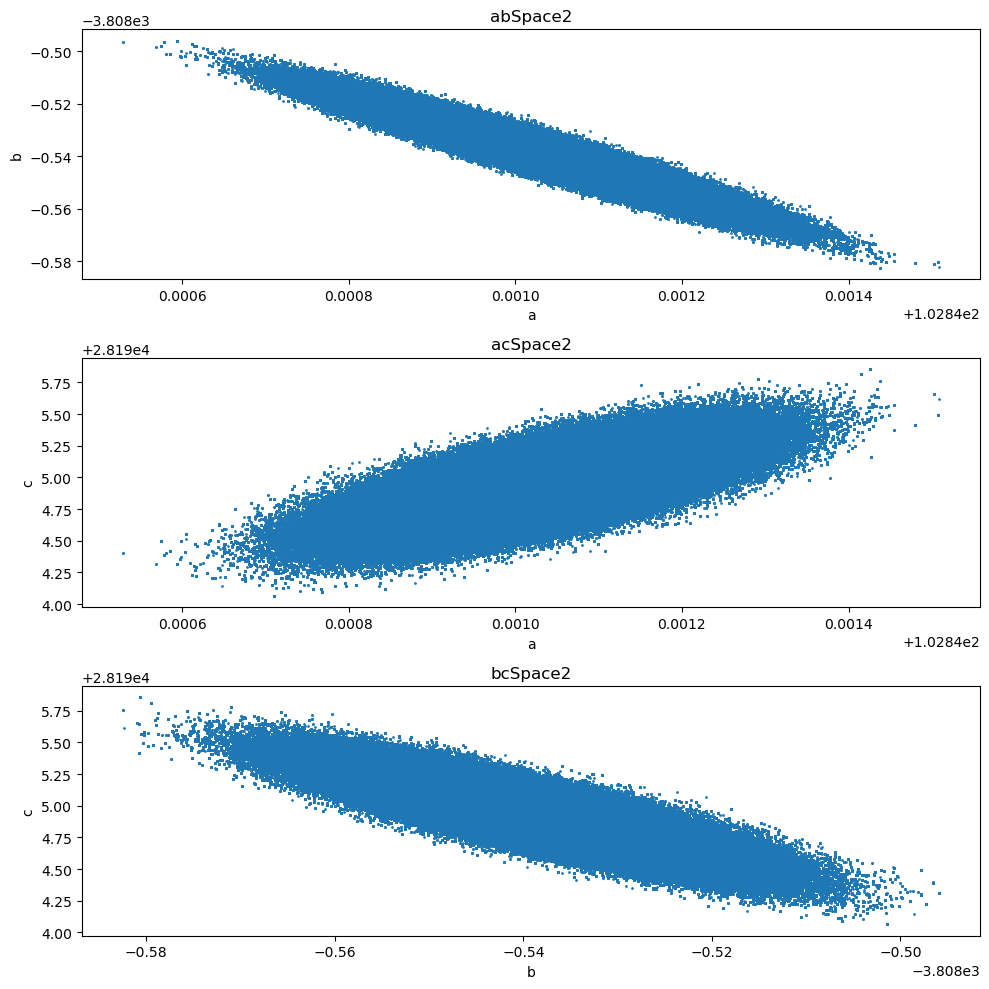

In [ ]:
# mcmcarr2 analysis
import matplotlib.pyplot as plt
abSpace2 = mcmcarr[0:2,:]
acSpace2 = mcmcarr[[0,2],:]
bcSpace2 = mcmcarr[[1,2],:]


fig, ax = plt.subplots(3,1, figsize=(10,10))
ax[0].scatter(abSpace2[0], abSpace2[1], s=1)
ax[0].set_xlabel('a')
ax[0].set_ylabel('b')
ax[0].set_title('abSpace2')

ax[1].scatter(acSpace2[0], acSpace2[1], s=1)
ax[1].set_xlabel('a')
ax[1].set_ylabel('c')
ax[1].set_title('acSpace2')


ax[2].scatter(bcSpace2[0], bcSpace2[1], s=1)
ax[2].set_xlabel('b')
ax[2].set_ylabel('c')
ax[2].set_title('bcSpace2')

plt.tight_layout()
plt.show()

In [119]:
print(f"sig_a = {mcmcarr[0].std()}, \nsig_b = {mcmcarr[1].std()}, \nsig_c = {mcmcarr[2].std()}")



sig_a = 9.796845609116278e-05, 
sig_b = 0.009475428937510555, 
sig_c = 0.18949651867671582


niter: 8210
ncall: 14295
nsamples: 9210
logz: -5881846967.347 +/- 10.819
h: 117057.048 
logzerr: 10.819290543996143
Best-fit parameters: 102.841 +/- 0.000
Best-fit parameters: -3808.539 +/- 0.014
Best-fit parameters: 28194.932 +/- 0.273


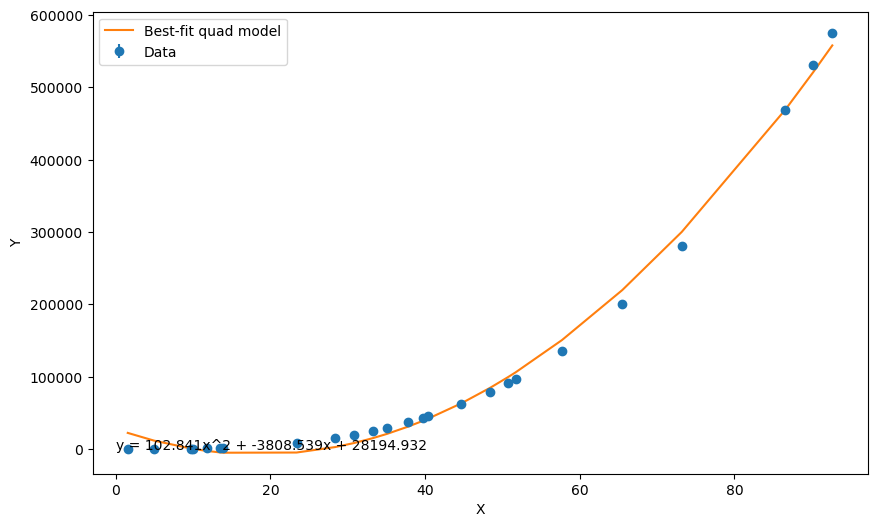

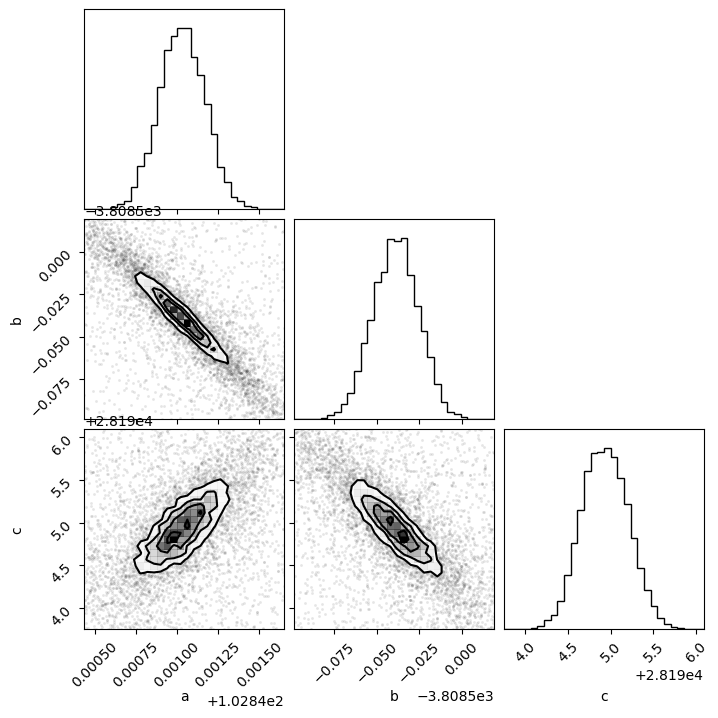

In [10]:
#define prior

def prior_quadratic(x):
    theta = (np.array([9.796845609116278e-05*20, 
                      0.009475428937510555*20,
                      0.18949651867671582*20
                      ]) * x 
    + np.array([102.84103167 -9.796845609116278e-05*10,
                -3808.53901512 - 0.009475428937510555*10, 
                28194.93525741 - 0.18949651867671582*10])
    )
    return theta

def loglike_quadratic(theta):
    model = quadratic(X,theta) # Change the model here
    loglikelihood = -0.5*np.sum((Y-model)**2/var)
    return(loglikelihood)

result_quadratic = nestle.sample(loglike_quadratic, prior_quadratic, 3,npoints=1000, method='single')
print(result_quadratic.summary(), f"\nlogzerr: {result_quadratic.logzerr}")
p_quadratic, cov_quadratic = nestle.mean_and_cov(result_quadratic.samples, result_quadratic.weights)
print(f"Best-fit parameters: {p_quadratic[0]:.3f} +/- {np.sqrt(cov_quadratic[0,0]):.3f}")
print(f"Best-fit parameters: {p_quadratic[1]:.3f} +/- {np.sqrt(cov_quadratic[1,1]):.3f}")
print(f"Best-fit parameters: {p_quadratic[2]:.3f} +/- {np.sqrt(cov_quadratic[2,2]):.3f}")

plt.figure(figsize=(10, 6))
plt.errorbar(X, Y, np.sqrt(var), fmt='o', label='Data')
plt.plot(X, quadratic(X, p_quadratic), label='Best-fit quad model')
plt.xlabel('X')
plt.ylabel('Y')
plt.text(0.1,13, f"y = {p_quadratic[0]:.3f}x^2 + {p_quadratic[1]:.3f}x + {p_quadratic[2]:.3f}")
plt.legend()
fig = corner.corner(result_quadratic.samples,weights=result_quadratic.weights, labels=['a', 'b','c'],
                    range=[0.99999, 0.99999,0.99999], bins=30)
plt.show()

### cubic function

niter: 27285
ncall: 70764
nsamples: 28285
logz: -28.212 +/-  0.157
h: 24.599 
logzerr: 0.15684034859923568
Best-fit parameters: 0.750 +/- 0.000
Best-fit parameters: -2.500 +/- 0.001
Best-fit parameters: 6.795 +/- 0.038
Best-fit parameters: 17.040 +/- 0.374


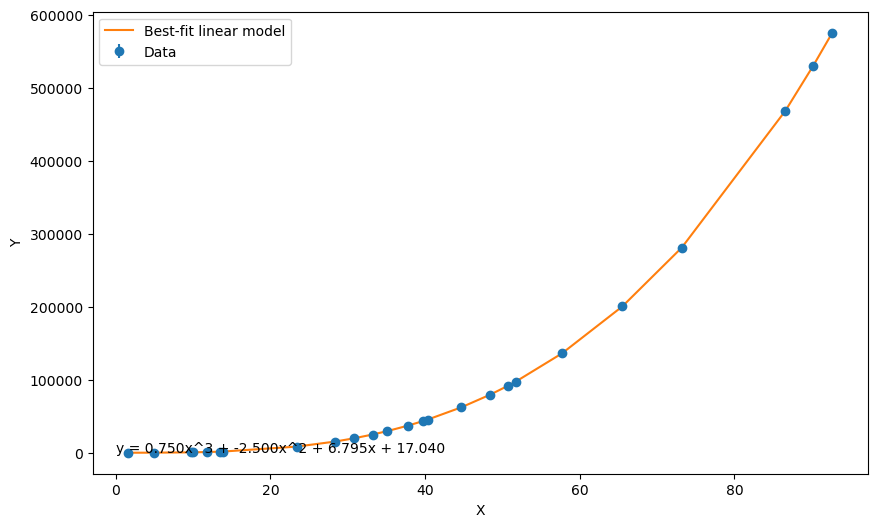

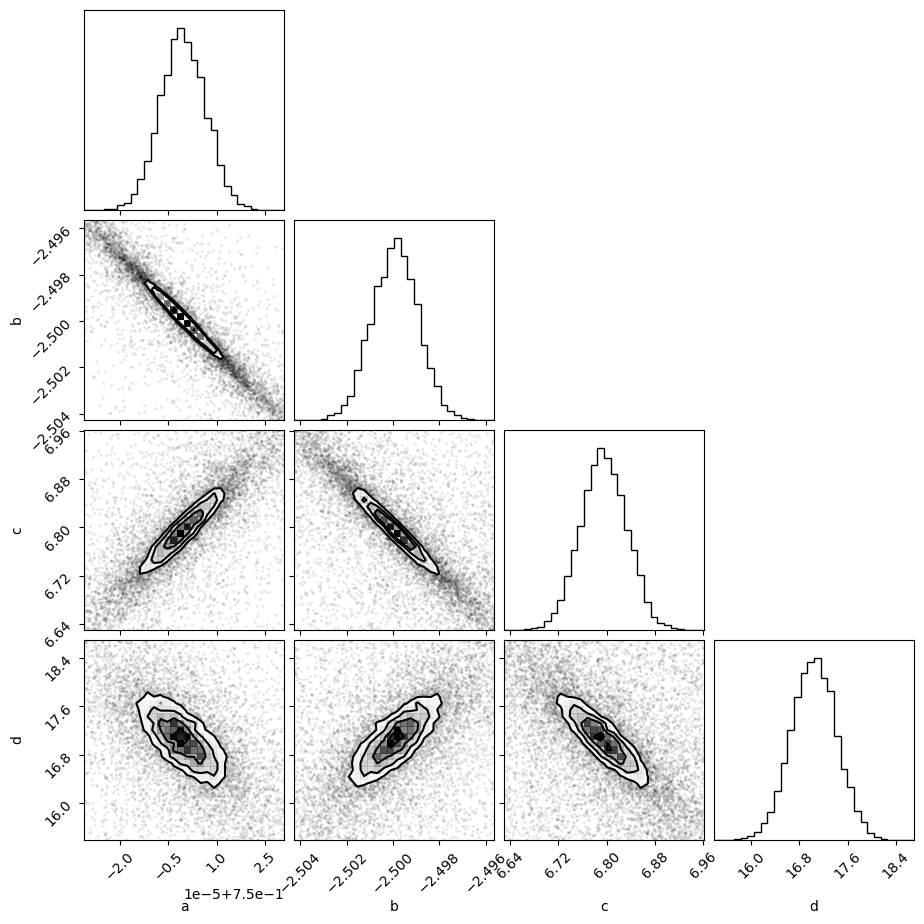

In [ ]:
def prior_cubic(x):
    theta = np.array([1,0.05,0.7,10]) * x + np.array([0.75-0.5,-2.5 - 0.05/2,6.8 - 0.7/2,17.1 - 5])
    return theta


def loglike_cube(theta):
    model = cube(X,theta) # Change the model here
    loglikelihood = -0.5*np.sum((Y-model)**2/var)
    return(loglikelihood)

result_cube = nestle.sample(loglike_cube, prior_cubic, 4,npoints=1000, method='single')
print(result_cube.summary(), f"\nlogzerr: {result_cube.logzerr}")
p_cube, cov_cube = nestle.mean_and_cov(result_cube.samples, result_cube.weights)
print(f"Best-fit parameters: {p_cube[0]:.3f} +/- {np.sqrt(cov_cube[0,0]):.3f}")
print(f"Best-fit parameters: {p_cube[1]:.3f} +/- {np.sqrt(cov_cube[1,1]):.3f}")
print(f"Best-fit parameters: {p_cube[2]:.3f} +/- {np.sqrt(cov_cube[2,2]):.3f}")
print(f"Best-fit parameters: {p_cube[3]:.3f} +/- {np.sqrt(cov_cube[3,3]):.3f}")



plt.figure(figsize=(10, 6))
plt.errorbar(X, Y, np.sqrt(var), fmt='o', label='Data')
plt.plot(X, cube(X, p_cube), label='Best-fit linear model')
plt.xlabel('X')
plt.ylabel('Y')
plt.text(0.1,13, f"y = {p_cube[0]:.3f}x^3 + {p_cube[1]:.3f}x^2 + {p_cube[2]:.3f}x + {p_cube[3]:.3f}")
plt.legend()

fig = corner.corner(result_cube.samples,weights=result_cube.weights, labels=['a', 'b','c','d'],
                    range=[0.99999, 0.99999,0.99999,0.99999], bins=30)
plt.show()

### Power law

In [4]:
import scipy
def func(x, a, b, c):
    y = a * x**b + c
    return y

popt, pcov = scipy.optimize.curve_fit(func, X, Y, sigma = np.sqrt(var))
a = popt[0]; b = popt[1]; c = popt[2]
sig_a = np.sqrt(pcov[0][0]); sig_b = np.sqrt(pcov[1][1]); sig_c = np.sqrt(pcov[2][2])
print(f"a = {a}, b = {b}, c = {c}")
print(f"sigma = {sig_a}, {sig_b}, {sig_c}")

a = 0.5934843638037636, b = 3.0440063265440642, c = -220.79804875162046
sigma = 0.004029210563006845, 0.0015045015648491227, 56.271283994802964


niter: 28789
ncall: 55461
nsamples: 29789
logz: -1313058.614 +/-  0.163
h: 26.496 
logzerr: 0.16277459292528682
Best-fit parameters: 0.593 +/- 0.000
Best-fit parameters: 3.044 +/- 0.000
Best-fit parameters: -220.797 +/- 0.164


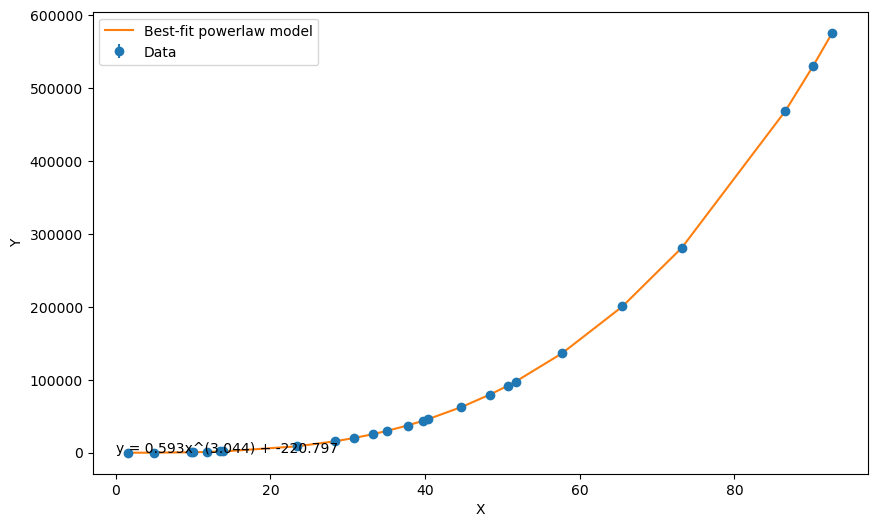

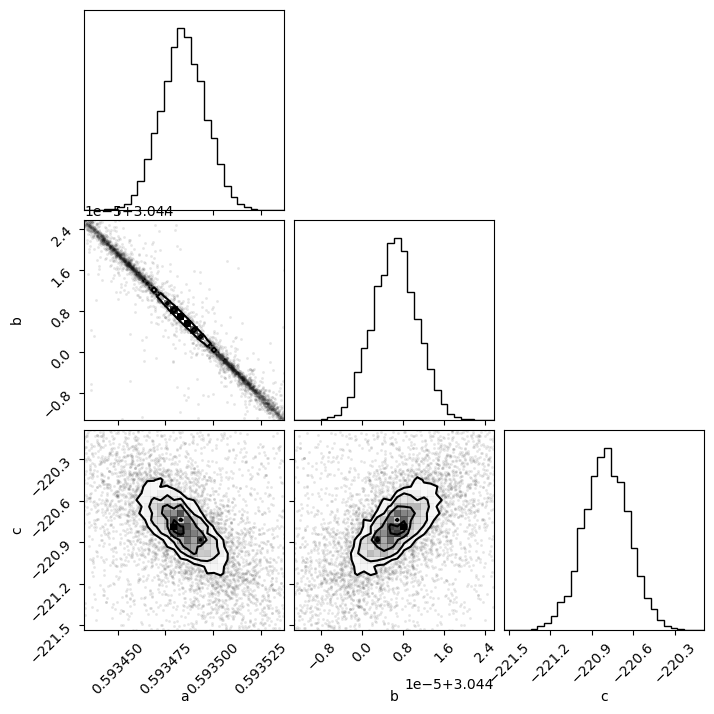

In [8]:
def prior_powerlaw(x):
    theta = 20*np.array([sig_a,sig_b,sig_c]) * x + np.array([a,b,c]) - 10*np.array([sig_a,sig_b,sig_c])
    return theta

def loglike_powerlaw(theta):
    model = powerlaw(X,theta) # Change the model here
    loglikelihood = -0.5*np.sum((Y-model)**2/var)
    return(loglikelihood)

result_powerlaw = nestle.sample(loglike_powerlaw, prior_powerlaw, 3,npoints=1000, method='single')
print(result_powerlaw.summary(), f"\nlogzerr: {result_powerlaw.logzerr}")
p_powerlaw, cov_powerlaw = nestle.mean_and_cov(result_powerlaw.samples, result_powerlaw.weights)
print(f"Best-fit parameters: {p_powerlaw[0]:.3f} +/- {np.sqrt(cov_powerlaw[0,0]):.3f}")
print(f"Best-fit parameters: {p_powerlaw[1]:.3f} +/- {np.sqrt(cov_powerlaw[1,1]):.3f}")
print(f"Best-fit parameters: {p_powerlaw[2]:.3f} +/- {np.sqrt(cov_powerlaw[2,2]):.3f}")


plt.figure(figsize=(10, 6))
plt.errorbar(X, Y, np.sqrt(var), fmt='o', label='Data')
plt.plot(X, powerlaw(X, p_powerlaw), label='Best-fit powerlaw model')
plt.xlabel('X')
plt.ylabel('Y')
plt.text(0.1,13, f"y = {p_powerlaw[0]:.3f}x^({p_powerlaw[1]:.3f}) + {p_powerlaw[2]:.3f}")
plt.legend()

fig = corner.corner(result_powerlaw.samples,weights=result_powerlaw.weights, labels=['a', 'b','c'],
                    range=[0.99999, 0.99999,0.99999], bins=30)
plt.show()
